In [ ]:
!pip install torchview

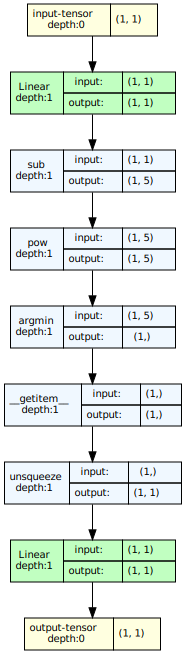

In [ ]:
import torch
import torch.nn as nn
from torchview import draw_graph

class quantized (nn.Module):

  def __init__(self):
    super().__init__()

    self.enc = nn.Linear(1,1)
    self.codebook = nn.Parameter(torch.tensor([-10.0,0.0,3.0,6,0]))
    self.dec = nn.Linear(1,1)


  def forward(self,x):
    z = self.enc(x)
    closest = torch.argmin((z - self.codebook)**2,dim= -1)
    e_j = self.codebook[closest].unsqueeze(0)
    x_hat = self.dec(e_j)
    return x_hat

model = quantized()
out = model(torch.tensor([1.0]))

out.backward()

# visualizing the computational flow
model_graph = draw_graph(model, input_size=(1,1))
model_graph.visual_graph


#print(model.enc.weight.grad,model.dec.weight.grad)

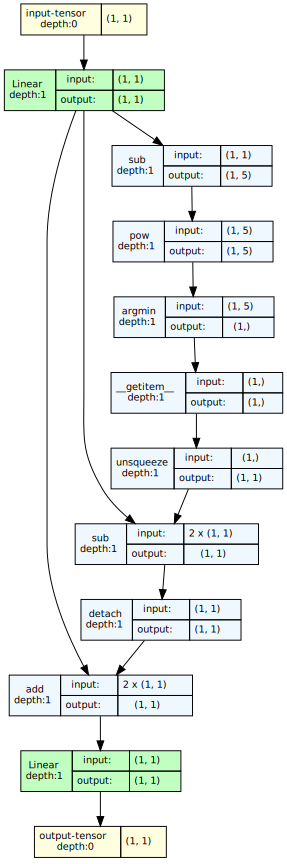

In [ ]:
import torch
import torch.nn as nn
from torchview import draw_graph

class quantized (nn.Module):

  def __init__(self):
    super().__init__()

    self.enc = nn.Linear(1,1)
    self.codebook = nn.Parameter(torch.tensor([-10.0,0.0,3.0,6,0]))
    self.dec = nn.Linear(1,1)


  def forward(self,x):
    z = self.enc(x)
    closest = torch.argmin((z - self.codebook)**2,dim= -1)
    e_j = self.codebook[closest].unsqueeze(0)
    e_j = z + (e_j - z).detach() # to flow the gradients
    x_hat = self.dec(e_j)
    return x_hat

model = quantized()
out = model(torch.tensor([1.0]))

out.backward()

# visualizing the computational flow
model_graph = draw_graph(model, input_size=(1,1))
model_graph.visual_graph


#print(model.enc.weight.grad,model.dec.weight.grad)

In [38]:
# implementing vector quantizer
import torch
class VectorQuantizer(nn.Module):

  def __init__(self,codebook_size, embeddding_dim):
    super().__init__()

    self.embedding = nn.Embedding(codebook_size, embeddding_dim)
    self.embedding.weight.data.uniform_(-1/codebook_size, 1/codebook_size)

    self.codebook_size = codebook_size
    self.embedding_dim = embeddding_dim

  def forward(self,x, efficient=True):

    if not efficient:
      # x -> (B,L)
      # emb -> (C, L)
      # we want each sample in the batch to undergo operation with entire embedding matrix.
      # so we reshape the x and q as . x -> (B,1,L) and q-> (B,C,L)
      z = x.unsqueeze(1)
      batch_size = x.shape[0]
      emb = self.embedding.weight.unsqueeze(0).repeat(batch_size,1,1)
      distance = torch.sum((z - emb)**2,dim=-1)
      return distance

    else:

      # we need to do (x-emb)**2  , which is x**2 - 2*x*emb + emb**2

      x2 = torch.sum(x**2, dim = -1,keepdim=True)
      emb2 = torch.sum(self.embedding.weight **2 ,dim = -1).unsqueeze(0)
      xemb = torch.matmul(x,self.embedding.weight.transpose(-2,-1))
      distance = x2 - 2*xemb + emb2

    closest = torch.argmin(distance, dim=-1)

    # we can now take the closest latents (quantized latents) directly with embedding matrix by passing in the indices

    qunatized_latents = self.embedding(closest)
    return qunatized_latents


vq = VectorQuantizer(6,2)
x = torch.randn((4,2))
out = vq(x)
print(out.shape)

torch.Size([4, 2])


In [39]:
# simple linear vqvae
import torch.nn as nn

class LinearVectorQuantizedVAE(nn.Module):

  def __init__(self,latent_dim=2,codebook_size = 512):
    super().__init__()

    self.encoder = nn.Sequential(
        nn.Linear(28*28, 128),
        nn.ReLU(),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64,latent_dim),
    )

    self.decoder = nn.Sequential(
        nn.Linear(latent_dim,64),
        nn.ReLU(),
        nn.Linear(64,128),
        nn.ReLU(),
        nn.Linear(128,28*28),
        nn.Sigmoid()
    )

    self.vq = VectorQuantizer(codebook_size,latent_dim)

  def forward_enc(self,x):
    z = self.encoder(x)
    return z

  def forward_vq(self,x):
    z = self.forward_enc(x)
    codes = self.vq(z)

    # codebook and commitment loss #
    codebook_loss = torch.mean((codes - z.detach())**2)
    commitment_loss = torch.mean((codes.detach() - z)**2)

    codes = z + (codes-z).detach()
    return z,codes,codebook_loss,commitment_loss


  def forward_dec(self,x):
    z,codes,codebook_loss,commitment_loss  = self.forward_vq(x)
    x_hat = self.decoder(codes)
    x_hat = x_hat.reshape(-1,1,28,28)
    return z,x_hat,codes,codebook_loss,commitment_loss

  def forward (self,x):
    x = x.flatten(1)
    return self.forward_dec(x)


linearvqvae = LinearVectorQuantizedVAE()
x = torch.randn((4,1,28,28))
encoded,decoded,codes,codebook_loss,commitment_loss = linearvqvae(x)

In [31]:
import numpy as np
encoded_data_per_eval = []

encoded = torch.randn((64,2))
labels = torch.randn((64,1))
encoded_evaluations = torch.cat((encoded,labels),axis = -1)
encoded_data_per_eval.append(encoded_evaluations)


encoded2 = torch.randn((64,2))
labels2 = torch.randn((64,1))
encoded_evaluations2 = torch.cat((encoded2,labels2),axis = -1)
encoded_data_per_eval.append(encoded_evaluations2)


z = torch.cat(encoded_data_per_eval,axis = 0)
print(z.shape)
y =[]
y.append(z)
random = torch.randn((128,3))

y.append(random)

for i in y:
  print(np.array(i).shape)

torch.Size([128, 3])
(128, 3)
(128, 3)


In [34]:
from tqdm import tqdm
import numpy as np

def train(model,
          trainloader,
          testloader,
          batch_size,
          training_iterations,
          evaluation_iterations,
          model_type="VQVAE"):


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    optimizer =torch.optim.Adam(model.parameters(), lr=0.0005)

    train_loss = []
    evaluation_loss = []

    encoded_data_per_eval = []
    quantized_encoded_data_per_eval = [] if model_type == "VQVAE" else None
    train_losses = []
    evaluation_losses = []

    pbar = tqdm(range(training_iterations))

    train = True

    step_counter = 0
    while train:

        for images, labels in trainloader:

            images = images.to(device)

            if model_type == "VQVAE":
                encoded,decoded, quantized_encoded, codebook_loss, commitment_loss = model(images)
                reconstruction_loss = torch.mean((images-decoded)**2)
                loss = reconstruction_loss + codebook_loss +  0.25*commitment_loss

            train_loss.append(loss.item())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if step_counter % evaluation_iterations == 0:

                model.eval()

                encoded_evaluations = []
                if model_type == "VQVAE":
                    quantized_encoded_evaluations = []

                for images, labels in testloader:

                    images = images.to(device)

                    if model_type == "VQVAE":
                        encoded, decoded, quantized_encoded, codebook_loss, commitment_loss = model(images)
                        reconstruction_loss = torch.mean((images-decoded)**2)
                        loss = reconstruction_loss + codebook_loss +  0.25*commitment_loss

                    evaluation_loss.append(loss.item())

                    encoded, labels = encoded.cpu(), labels.reshape(-1,1)

                    encoded_evaluations.append(torch.cat((encoded.flatten(1), labels), axis=-1))

                    if model_type == "VQVAE":
                        quantized_encoded = quantized_encoded.cpu()
                        quantized_encoded_evaluations.append(torch.cat((quantized_encoded.flatten(1), labels), axis=-1))


                encoded_data_per_eval.append(torch.concatenate(encoded_evaluations).detach())
                if model_type == "VQVAE":
                    quantized_encoded_data_per_eval.append(torch.concatenate(quantized_encoded_evaluations).detach())


                train_loss = np.mean(train_loss)
                evaluation_loss = np.mean(evaluation_loss)

                train_losses.append(train_loss)
                evaluation_losses.append(evaluation_loss)

                train_loss = []
                evaluation_loss = []

                model.train()

            step_counter += 1
            pbar.update(1)


            if step_counter >= training_iterations:
                print("Completed Training!")
                train = False
                break

    encoded_data_per_eval = [np.array(i) for i in encoded_data_per_eval]

    if model_type == "VQVAE":
        quantized_encoded_data_per_eval = [np.array(i) for i in quantized_encoded_data_per_eval]

    print("Final Training Loss", train_losses[-1])
    print("Final Evaluation Loss", evaluation_losses[-1])

    return model, train_losses, evaluation_losses, encoded_data_per_eval, quantized_encoded_data_per_eval

In [35]:
import torchvision
import torchvision.transforms as transforms

train_set  = torchvision.datasets.MNIST(
    root = './data',
    train = True,
    download = True,
    transform = transforms.ToTensor()
)

test_set  = torchvision.datasets.MNIST(
    root = './data',
    train = False,
    download = True,
    transform = transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(train_set,batch_size=128,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=128,shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 495kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.08MB/s]


In [40]:
(linear_vqvae, train_losses,
 evaluation_losses, linear_vqvae_encoded_data_per_eval,
 linear_vqvae_quantized_encoded_data_per_eval) = train(linearvqvae,
                                                       train_loader,
                                                       test_loader,
                                                       batch_size=64,
                                                       training_iterations=200,
                                                       evaluation_iterations=50,
                                                       model_type="VQVAE")

100%|██████████| 200/200 [00:10<00:00, 20.00it/s]

Completed Training!
Final Training Loss 0.06958338618278503
Final Evaluation Loss 0.06866767818603335


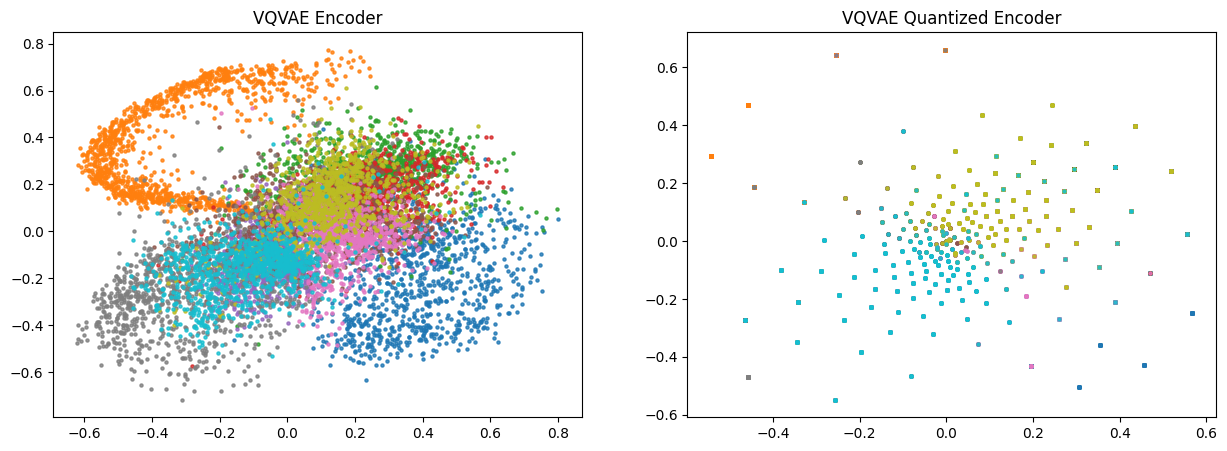

In [7]:
### Grab Encodings ###
import matplotlib.pyplot as plt
import pandas as pd
encoded_latent = linear_vqvae_encoded_data_per_eval[-1]
quantized_encoded_latent = linear_vqvae_quantized_encoded_data_per_eval[-1]

fig, ax = plt.subplots(1,2, figsize=(15,5))
fig, ax = plt.subplot(1,2, figsize=(15,5))

### Plot Continuous Encoded ###
encoded_latent = pd.DataFrame(encoded_latent, columns = ["x","y","class"])
encoded_latent = pd.DataFrame(encoded_latent, columns=["x", "y", "class"])

encoded_latent = encoded_latent.sort_values(by="class")
encoded_latent["class"] = encoded_latent["class"].astype(int).astype(str)
for grouper, group in encoded_latent.groupby("class"):
    ax[0].scatter(x=group["x"], y=group["y"], label=grouper, alpha=0.8, s=5)
ax[0].set_title("VQVAE Encoder")

### Plot Quantized ###
quantized_encoded_latent = pd.DataFrame(quantized_encoded_latent, columns=["x", "y", "class"])
quantized_encoded_latent = quantized_encoded_latent.sort_values(by="class")
quantized_encoded_latent["class"] = quantized_encoded_latent["class"].astype(int).astype(str)
for grouper, group in quantized_encoded_latent.groupby("class"):
    ax[1].scatter(x=group["x"], y=group["y"], label=grouper, alpha=0.8, s=5)
ax[1].set_title("VQVAE Quantized Encoder")
plt.show()

(1, 1, 28, 28)


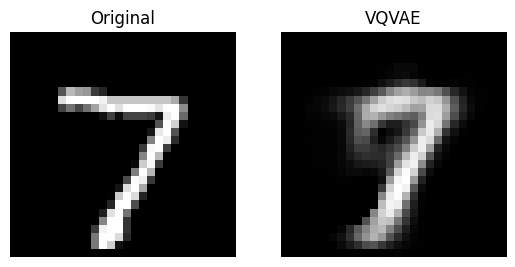

In [20]:
generated_index = 0

device = "cuda" if torch.cuda.is_available() else "cpu"
image, label = test_set[generated_index]
image = image.unsqueeze(0).to(device)


_,vqvae_reconstructed,_, *_ = linear_vqvae(image)

image = image.to("cpu")

vqvae_reconstructed = vqvae_reconstructed.to("cpu").detach().numpy()
print(vqvae_reconstructed.shape)
fig, ax = plt.subplots(1,2)

ax[0].imshow(image.squeeze(), cmap="gray")
ax[0].set_title("Original")
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].axis("off")


ax[1].imshow(vqvae_reconstructed.squeeze(), cmap="gray")
ax[1].set_title("VQVAE")
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].axis("off")


plt.show()